# Temperature Forecasting using Bidirectional LSTM

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Bidirectional,LSTM
from tensorflow.keras.models import load_model

Import the dataset

In [2]:
data1 = pd.read_csv("dataset_temperature/daily-min-temperatures.csv")

data1['Date'] = pd.to_datetime(data1['Date'])
data1.set_index("Date",inplace=True)
data1.index = pd.DatetimeIndex(data1.index).to_period("D")

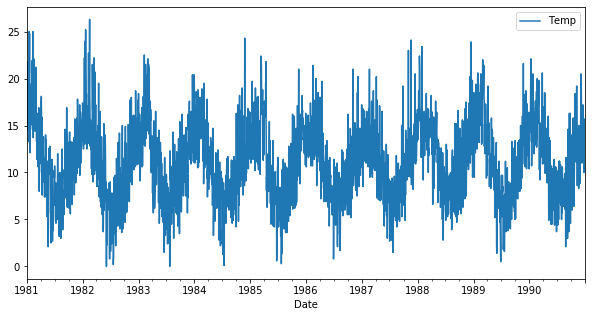

In [3]:
data1.plot(figsize=(10,5))

As evident through the plot, there clear sign of strong seasonal component but no obvious trend in the timeseries.

## Data Preprocessing

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
data = scaler.fit_transform(data1['Temp'].to_numpy().reshape(-1,1))

A LSTM model is very sensitive to the scale, so we need to normalize the data before feeding it to the model for training.

In [5]:
# Training and test data split
num_train = int(len(data)*0.7)
data_train,data_test = data[:num_train],data[num_train:]

In [6]:
# For n_features=3, Input: [[x1],[x2],[x3]] y: [[x4]]
def create_dataset(arr,n):
    X,y= [],[]
    for i in range(len(arr)-n-1):
        X.append(arr[i:i+n,0])
        y.append(arr[i+n,0])
    return np.array(X),np.array(y)

X_train,y_train = create_dataset(data_train,100)
X_test,y_test = create_dataset(data_test,100)

In [7]:
# Reshape
X_train = X_train.reshape(*X_train.shape,1)
y_train = y_train.reshape(*y_train.shape,1)

X_test = X_test.reshape(*X_test.shape,1)
y_test = y_test.reshape(*y_test.shape,1)

## Bidirectional LSTM

In [8]:
model = Sequential()
model.add(Bidirectional(LSTM(50),input_shape=(100,1)))
model.add(Dense(1))
model.compile(loss='mse',optimizer="adam")

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 100)               20800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Training the Bidirectional LSTM model
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64,verbose=1)

In [11]:
model = load_model("models/bidirectional_lstm.h5")

In [12]:
def forecast_temp(X,n_features,steps):
    X1 = X.tolist()
    for i in range(steps):
        a = np.array(X1[-100:])
        y_pred = model.predict(np.array(X1[-100:]).reshape(1,100,1))
        X1.append(y_pred[0])
    X1 = np.array(X1)
    return scaler.inverse_transform(X1)[-steps:]

In [13]:
n_features =100
forecast_days = 365
output = forecast_temp(data,n_features,forecast_days)

In [14]:
for i in range(forecast_days):
    data1.loc[data1.index[-1]+1,"Forecast"]=output[i][0]

## Forecast the min Temperature for next 1 year

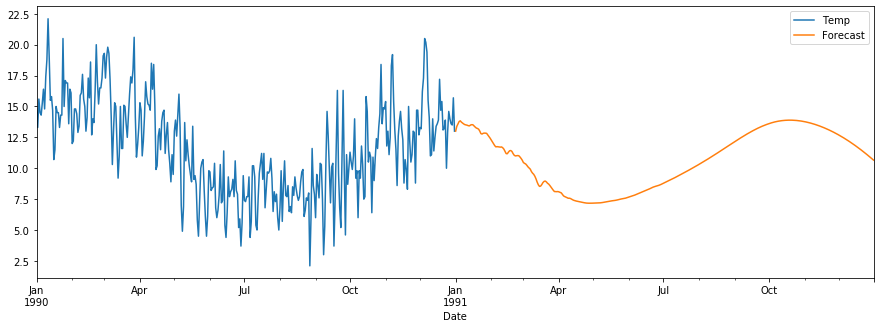

In [15]:
data1[-730:].plot(figsize=(15,5))